In [1]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler

from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
movies_TFIDF = pd.read_csv('3a movies_TFIDF.csv')
movies_GloVe = pd.read_csv('3b movies_GloVe.csv')
country_codes = pd.read_csv('country_codes.csv')

In [3]:
def get_numbers(str):
    """Return the integer numbers from a string in an array format."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').split()
    arr = [int(s) for s in arr if s.isdigit()]
    return arr

def get_country_codes(str):
    """Return the codes of the countries from a string."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').replace("'", "").split()
    arr = [s for s in arr if country_codes['Code'].str.contains(s).any()]
    return arr

def prepare_dataframe(movies):
    
    # Conversion
    movies['genres'] = movies['genres'].apply(lambda str: get_numbers(str))
    movies['production_companies'] = movies['production_companies'].apply(lambda str: get_numbers(str))
    movies['production_countries'] = movies['production_countries'].apply(lambda str: get_country_codes(str)) # This takes time
    
    # Get dummies
    mlb = MultiLabelBinarizer()
    genres = pd.DataFrame(mlb.fit_transform(movies['genres']), columns=mlb.classes)

    mlb = MultiLabelBinarizer()
    production_companies = pd.DataFrame(mlb.fit_transform(movies['production_companies']), columns=mlb.classes)

    mlb = MultiLabelBinarizer()
    production_countries = pd.DataFrame(mlb.fit_transform(movies['production_countries']), columns=mlb.classes)

    original_language = pd.get_dummies(movies['original_language'])
    
    # Rename the columns to unique names
    for i in range(genres.shape[1]):
        genres.rename(mapper={i : str(i) + '. genre'}, axis=1, inplace=True)
    
    for i in range(production_countries.shape[1]):
        production_countries.rename(mapper={i : str(i) + '. country'}, axis=1, inplace=True)
    
    movies = movies.drop(['id', 'title'], axis=1)
    
    # production_companies, original languages, production countries are not used, because of huge running time
    numeric = movies.drop(['adult', 'genres', 'original_language', 'production_companies', 'production_countries'], axis=1)
    categorical = movies[['adult']].join(genres)
    
    # Scale the numeric values to (0, 1) interval
    scaler = MinMaxScaler()
    numeric = scaler.fit_transform(numeric)
    
    movievectors = pd.DataFrame(numeric).join(categorical)
    
    return movievectors

In [4]:
movies_TFIDF = prepare_dataframe(movies_TFIDF)
movies_GloVe = prepare_dataframe(movies_GloVe)

In [5]:
# Sampling used to reduce running time
movies_TFIDF_sample = movies_TFIDF.sample(n=1000, random_state=98)
movies_GloVe_sample = movies_GloVe.sample(n=1000, random_state=98)

Use silhouette score for test purposes:

In [6]:
# 1. test: TF-IDF vs GloVe model and measure runtime
df1 = pd.DataFrame(columns=['Number of clusters', 'TF-IDF', 'TF-IDF runtime',
                                   'GloVe model', 'GloVe model runtime'])
for i in range(5, 51, 5):
    
    # K-Prototypes
    start1 = time.time()
    kproto_TFIDF = KPrototypes(n_clusters=i, max_iter=20, n_jobs=4)
    kproto_TFIDF.fit(movies_TFIDF_sample, categorical=[i for i in range(57,movies_TFIDF_sample.shape[1])])
    end1 = time.time()
    
    start2 = time.time()
    kproto_GloVe = KPrototypes(n_clusters=i, max_iter=20, n_jobs=4)
    kproto_GloVe.fit(movies_GloVe_sample, categorical=[i for i in range(57,movies_GloVe_sample.shape[1])])
    end2 = time.time()
    
    tfscore = silhouette_score(movies_TFIDF_sample, kproto_TFIDF.predict(movies_TFIDF_sample, categorical=[i for i in range(57,movies_TFIDF_sample.shape[1])]))
    elapsed1 = end1-start1
    
    emscore = silhouette_score(movies_GloVe_sample, kproto_GloVe.predict(movies_GloVe_sample, categorical=[i for i in range(57,movies_GloVe_sample.shape[1])]))
    elapsed2 = end2-start2
    
    scores = pd.DataFrame([[i, tfscore, elapsed1, emscore, elapsed2]],
                          columns=['Number of clusters', 'TF-IDF', 'TF-IDF runtime',
                                   'GloVe model', 'GloVe model runtime'])
    df1 = pd.concat([df1, scores], axis=0)

In [7]:
df1 = df1.reset_index().drop('index', axis=1)

<AxesSubplot:xlabel='Number of clusters', ylabel='Silhouette Score'>

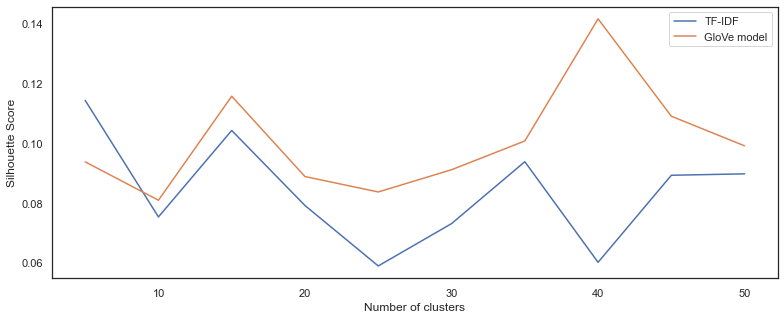

In [8]:
# Visualize the silhouette-score results
sns.set_theme(style="white")
plt.figure(figsize=(13,5))
plt.ylabel('Silhouette Score')

sns.lineplot(data = df1, x='Number of clusters', y='TF-IDF', label='TF-IDF')
sns.lineplot(data = df1, x='Number of clusters', y='GloVe model', label='GloVe model')

<AxesSubplot:xlabel='Number of clusters', ylabel='Runtime in seconds'>

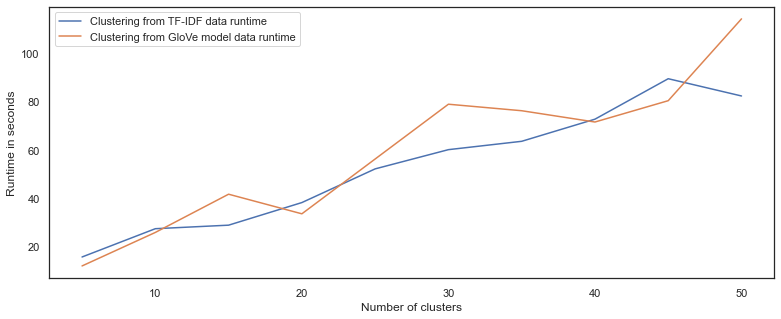

In [9]:
# Visualize the runtime results
sns.set_theme(style="white")
plt.figure(figsize=(13,5))
plt.ylabel('Runtime in seconds')

sns.lineplot(data = df1, x='Number of clusters', y='TF-IDF runtime', label='Clustering from TF-IDF data runtime')
sns.lineplot(data = df1, x='Number of clusters', y='GloVe model runtime',
             label='Clustering from GloVe model data runtime')

In [10]:
# 2. test: In the first test, the predictions were made only on the samples. Now let's try to predict the whole dataset.
df1 = pd.DataFrame(columns=['Number of clusters', 'TF-IDF', 'TF-IDF runtime',
                                   'GloVe model', 'GloVe model runtime'])
for i in range(5, 51, 5):
    
    # K-Prototypes
    start1 = time.time()
    kproto_TFIDF = KPrototypes(n_clusters=i, max_iter=20, n_jobs=4)
    kproto_TFIDF.fit(movies_TFIDF_sample, categorical=[i for i in range(57,movies_TFIDF_sample.shape[1])])
    end1 = time.time()
    
    start2 = time.time()
    kproto_GloVe = KPrototypes(n_clusters=i, max_iter=20, n_jobs=4)
    kproto_GloVe.fit(movies_GloVe_sample, categorical=[i for i in range(57,movies_GloVe_sample.shape[1])])
    end2 = time.time()
    
    tfscore = silhouette_score(movies_TFIDF, kproto_TFIDF.predict(movies_TFIDF, categorical=[i for i in range(57,movies_TFIDF.shape[1])]))
    elapsed1 = end1-start1
    
    emscore = silhouette_score(movies_GloVe, kproto_GloVe.predict(movies_GloVe, categorical=[i for i in range(57,movies_GloVe.shape[1])]))
    elapsed2 = end2-start2
    
    scores = pd.DataFrame([[i, tfscore, elapsed1, emscore, elapsed2]],
                          columns=['Number of clusters', 'TF-IDF', 'TF-IDF runtime',
                                   'GloVe model', 'GloVe model runtime'])
    df1 = pd.concat([df1, scores], axis=0)

In [11]:
df1 = df1.reset_index().drop('index', axis=1)

<AxesSubplot:xlabel='Number of clusters', ylabel='Silhouette Score'>

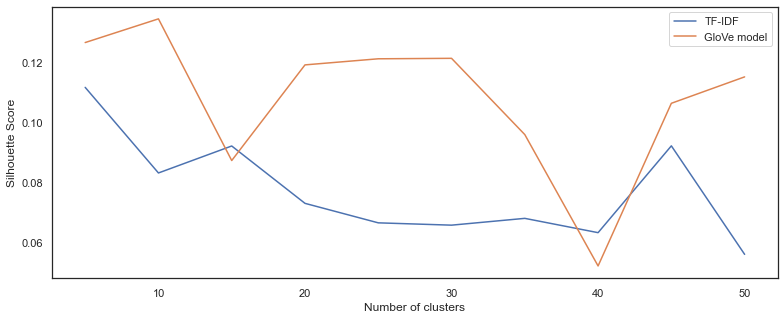

In [12]:
# Visualize the silhouette-score results
sns.set_theme(style="white")
plt.figure(figsize=(13,5))
plt.ylabel('Silhouette Score')

sns.lineplot(data = df1, x='Number of clusters', y='TF-IDF', label='TF-IDF')
sns.lineplot(data = df1, x='Number of clusters', y='GloVe model', label='GloVe model')

<AxesSubplot:xlabel='Number of clusters', ylabel='Runtime in seconds'>

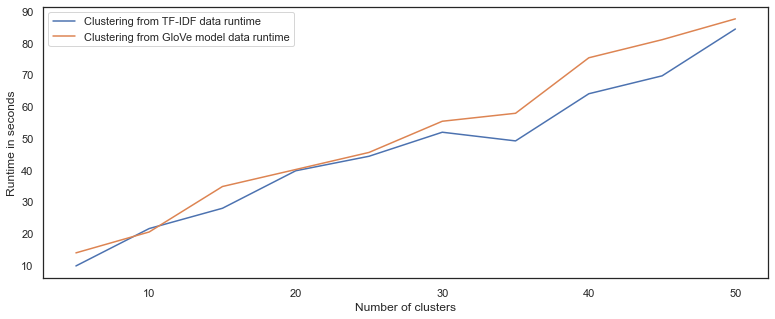

In [13]:
# Visualize the runtime results
sns.set_theme(style="white")
plt.figure(figsize=(13,5))
plt.ylabel('Runtime in seconds')

sns.lineplot(data = df1, x='Number of clusters', y='TF-IDF runtime', label='Clustering from TF-IDF data runtime')
sns.lineplot(data = df1, x='Number of clusters', y='GloVe model runtime',
             label='Clustering from GloVe model data runtime')